In [84]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import networkx as nx
from math import inf

In [85]:
class TreeStructure:
    def __init__(self, depth):
        self.depth = depth
        self.leaf_addr = []
        self._build_tree("")

    def _build_tree(self, current_addr):
        """build a binary tree with the given depth"""
        if len(current_addr) == self.depth:
            self.leaf_addr.append(current_addr)
        else:
            self._build_tree(current_addr + "L")
            self._build_tree(current_addr + "R")

In [95]:
# based on the edit distance to the target address
def compute_distance(leaf_addresses, target_address, B=8, tau=4):
    values = {}
    for address in leaf_addresses:
        edit_distance = sum(1 for a, b in zip(address, target_address) if a != b)
        # add noise to the value
        noise = np.random.normal(0, 1)
        # compute value as a function of edit distance
        values[address] = B * np.exp(-edit_distance / tau) + noise
    return values


In [87]:
def create_node(address):
    return {
        "address": address,
        "visit_count": 0,
        "value_sum": 0,
        "children": {}
    }

In [88]:
def mcts(tree, leaf_values, iterations, rollouts_per_leaf, c=np.sqrt(2)):
    root = create_node("")
    ucb_scores = {}

    def select(node):
        """select a leaf node using UCB"""
        path = []
        while node["children"]:
            path.append(node)
            for child in node["children"].values():
                #print(f"Child {child['address']} UCB before selection: {ucb_scores.get(child['address'], 'Not calculated')}")
                
                ucb_score = (child["value_sum"] / max(child["visit_count"], 1)) + \
                            c * np.sqrt(np.log(node["visit_count"] + 1) / max(child["visit_count"], 1))
                ucb_scores[child["address"]] = {
                    "ucb_score": ucb_score,
                    "visit_count": child["visit_count"]
                }

            # select child with highest UCB score
            node = max(
                node["children"].values(),
                key=lambda child: (child["value_sum"] / max(child["visit_count"], 1)) + \
                                c * np.sqrt(np.log(node["visit_count"] + 1) / max(child["visit_count"], 1))
            )
        return node, path


    def expand(node):
        """expand a node by adding its children and initializing UCB scores"""
        if len(node["address"]) < tree.depth:
            left_child = create_node(node["address"] + "L")
            right_child = create_node(node["address"] + "R")
            
            node["children"]["L"] = left_child
            node["children"]["R"] = right_child
            
            
            ucb_scores[left_child["address"]] = {
                "ucb_score": 0.0,
                "visit_count": 0
            }
            ucb_scores[right_child["address"]] = {
                "ucb_score": 0.0,
                "visit_count": 0
            }


    def rollout(node):
        """Perform rollouts and return the average leaf value. Random simulation"""
        values = []
        for _ in range(rollouts_per_leaf):
            values.append(leaf_values.get(node["address"], 0) + np.random.uniform(-0.5, 0.5))
        return np.mean(values)


    def backpropagate(path, value):
        for node in reversed(path):
            print(f"Before Backpropagate: Node {node['address']} Visit: {node['visit_count']}, Value Sum: {node['value_sum']}")
            node["visit_count"] += 1
            node["value_sum"] += value
            print(f"After Backpropagate: Node {node['address']} Visit: {node['visit_count']}, Value Sum: {node['value_sum']}")


    for _ in range(iterations):
        # traverse tree using UCB
        leaf, path = select(root)

        # add children to the leaf if not already expanded
        if not leaf["children"] and len(leaf["address"]) < tree.depth:
            expand(leaf)

        # random simulation to get a value
        value = rollout(leaf)

        # update path with the value
        backpropagate(path + [leaf], value)

    # return the best action from the root
    best_child = max(root["children"].values(), key=lambda child: child["value_sum"] / max(child["visit_count"], 1))
    return best_child["address"], ucb_scores

In [108]:
def visualize_tree(tree, ucb_scores):
    """Visualize the binary tree and highlight the target and snowcap nodes"""
    G = nx.DiGraph()
    
    # add nodes and edges
    for address in tree.leaf_addr:
        for i in range(len(address)):
            parent = address[:i]
            child = address[:i+1]
            G.add_edge(parent, child)
            G.nodes[parent]['subset_key'] = len(parent)
            G.nodes[child]['subset_key'] = len(child)

    pos = nx.multipartite_layout(G, subset_key='subset_key')

    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, node_size=500, node_color="lightblue", font_size=10)

    # show ucbs and visit counts in plot
    for node, (x, y) in pos.items():
        ucb_data = ucb_scores.get(node, {"ucb_score": 0.0, "visit_count": 0})
        plt.text(
            x, y + 0.03,
            f"UCB: {ucb_data['ucb_score']:.2f}\nVisits: {ucb_data['visit_count']}",
            fontsize=8, color="purple", ha="center"
        )



Before Backpropagate: Node  Visit: 0, Value Sum: 0
After Backpropagate: Node  Visit: 1, Value Sum: -0.07295861903609986
Before Backpropagate: Node L Visit: 0, Value Sum: 0
After Backpropagate: Node L Visit: 1, Value Sum: 0.015401567720180576
Before Backpropagate: Node  Visit: 1, Value Sum: -0.07295861903609986
After Backpropagate: Node  Visit: 2, Value Sum: -0.05755705131591929
Before Backpropagate: Node LL Visit: 0, Value Sum: 0
After Backpropagate: Node LL Visit: 1, Value Sum: -0.20655545786412546
Before Backpropagate: Node L Visit: 1, Value Sum: 0.015401567720180576
After Backpropagate: Node L Visit: 2, Value Sum: -0.19115389014394488
Before Backpropagate: Node  Visit: 2, Value Sum: -0.05755705131591929
After Backpropagate: Node  Visit: 3, Value Sum: -0.26411250918004475
Before Backpropagate: Node R Visit: 0, Value Sum: 0
After Backpropagate: Node R Visit: 1, Value Sum: -0.16042085981894844
Before Backpropagate: Node  Visit: 3, Value Sum: -0.26411250918004475
After Backpropagate: No

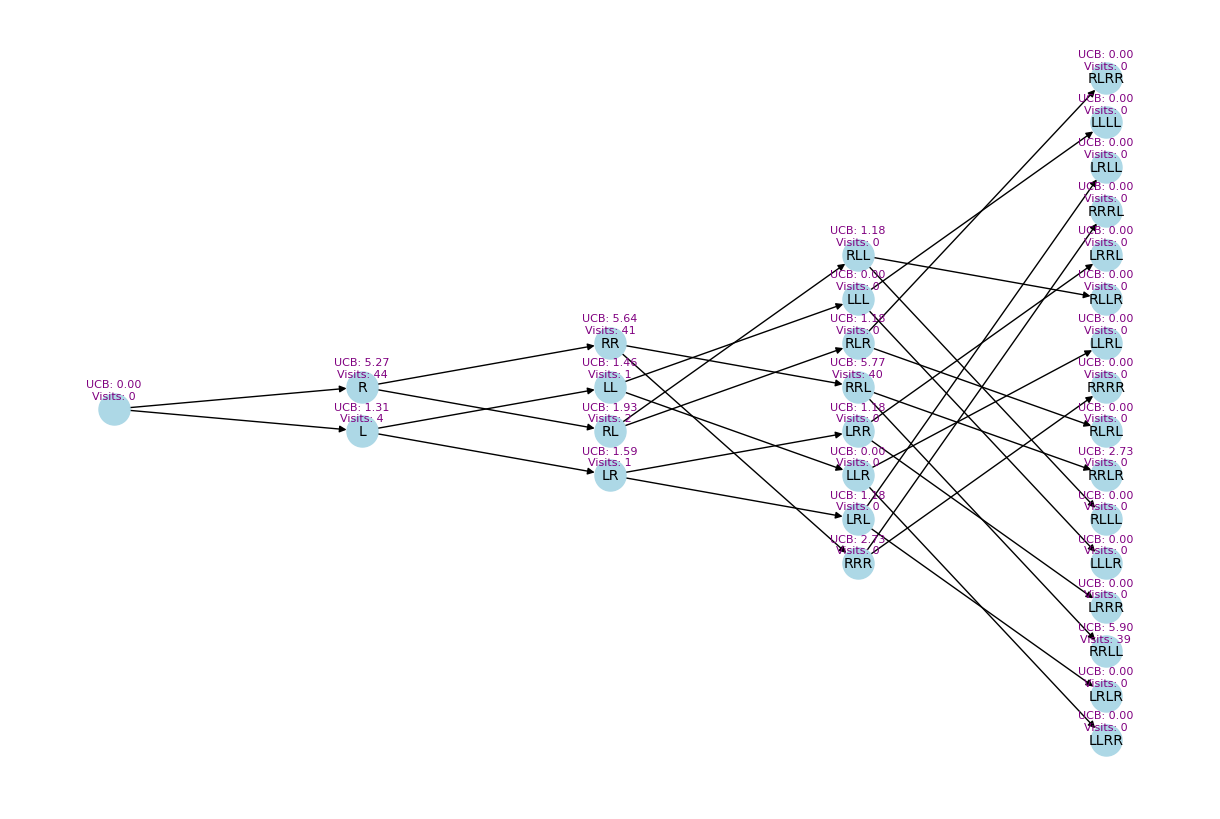

In [111]:
depth = 4
tree = TreeStructure(depth)
target_address = random.choice(tree.leaf_addr)
leaf_values = compute_distance(tree.leaf_addr, target_address)

# perform MCTS
iterations = 50
rollouts_per_leaf = 5
best_leaf, ucb_scores = mcts(tree, leaf_values, iterations, rollouts_per_leaf)
print("UCB Scores and Visit Counts:", ucb_scores)

# viz
visualize_tree(tree,  ucb_scores)

print("Target Address:", target_address)
print("Best Leaf Address Found:", best_leaf)